# Anomalies Threshold Definition

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import json

from src.data.synthetic_anomalies.anomalies import NoiseFactory
from src.data.spectrum_decomposition.spectrum import SpectrumDecomposition
from src.data.utils import SPECTRUMS
from src.data.utils import add_type_column
from src.statistical_methods.hmm.hmm import HMM

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Load Data

In [24]:

tl_prev = pd.read_parquet("data/cleaned_data/TL_add_data_without_duplicates.parquet")
tl_prev = add_type_column(tl)
tl_prev = tl[tl["type"] == "100440"]
#tl['date'].value_counts()
tl_prev

,Unnamed: 0,id,manipulator,date,time,timeindex,motorposition,speedsetpoint,torquefeedforward,torqueactual,type,robot_type,robot
296900,137858,7600-100440,TRACK_1,2024-01-02,12:25:35,13.075,372.131,-45.2737,0.0,-2.20981,100440,7600,7600-100440
296901,137859,7600-100440,TRACK_1,2024-01-02,12:25:35,12.624,482.799,-45.0835,0.0,-1.87446,100440,7600,7600-100440
296902,137860,7600-100440,TRACK_1,2024-01-02,12:25:35,12.515,509.465,-44.3226,0.0,-3.00268,100440,7600,7600-100440
296903,137861,7600-100440,TRACK_1,2024-01-02,12:25:35,9.498,1249.350,-44.7031,0.0,-2.22477,100440,7600,7600-100440
296904,137862,7600-100440,TRACK_1,2024-01-02,12:25:35,9.435,1264.160,-44.5128,0.0,-2.14203,100440,7600,7600-100440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12062690,69349,7600-100440,TRACK_1,2020-10-20,11:15:19,28.120,3491.590,22.8271,0.0,-15.23570,100440,7600,7600-100440
12062691,69350,7600-100440,TRACK_1,2020-10-20,11:15:19,28.129,3492.500,20.1639,0.0,-13.57860,100440,7600,7600-100440
12062692,69351,7600-100440,TRACK_1,2020-10-20,11:15:19,28.138,3493.330,18.0715,0.0,-13.05670,100440,7600,7600-100440
12062693,69352,7600-100440,TRACK_1,2020-10-20,11:15:19,28.147,3494.110,17.8812,0.0,-12.75520,100440,7600,7600-100440


In [22]:
tl = pd.read_csv('../../preprocessed/tracks.csv')


,Unnamed: 0,id,manipulator,date,time,timeindex,motorposition,speedsetpoint,torquefeedforward,torqueactual
0,0,6640-101753,TRACK_1,2021-03-01,10:37:33,0.010,6400.000,0.000000,0.0,0.015558
1,1,6640-101753,TRACK_1,2021-03-01,10:37:33,0.021,6400.000,-0.380452,0.0,-0.089100
2,2,6640-101753,TRACK_1,2021-03-01,10:37:33,0.031,6400.000,-0.380452,0.0,-0.029362
3,3,6640-101753,TRACK_1,2021-03-01,10:37:33,0.040,6400.000,0.000000,0.0,-0.125822
4,4,6640-101753,TRACK_1,2021-03-01,10:37:33,0.049,6400.000,-0.760903,0.0,0.006727
...,...,...,...,...,...,...,...,...,...,...
12074730,1376,6640-102092,TRACK_1,2020-11-24,10:07:56,13.604,259.100,-28.724100,0.0,19.100700
12074731,1377,6640-102092,TRACK_1,2020-11-24,10:07:56,13.613,257.369,-25.109800,0.0,19.640900
12074732,1378,6640-102092,TRACK_1,2020-11-24,10:07:56,13.623,256.322,-24.348900,0.0,21.043400
12074733,1379,6640-102092,TRACK_1,2020-11-24,10:07:56,13.632,255.355,-22.256400,0.0,21.009700


In [25]:

tl['key'] = tl['id'] + "|" + tl['date'] + "|" + tl['time']
tl

,Unnamed: 0,id,manipulator,date,time,timeindex,motorposition,speedsetpoint,torquefeedforward,torqueactual,type,robot_type,robot,key
0,0,6640-101753,TRACK_1,2021-03-01,10:37:33,0.010,6400.000,0.000000,0.0,0.015558,101753,6640,6640-101753,6640-101753|2021-03-01|10:37:33
1,1,6640-101753,TRACK_1,2021-03-01,10:37:33,0.021,6400.000,-0.380452,0.0,-0.089100,101753,6640,6640-101753,6640-101753|2021-03-01|10:37:33
2,2,6640-101753,TRACK_1,2021-03-01,10:37:33,0.031,6400.000,-0.380452,0.0,-0.029362,101753,6640,6640-101753,6640-101753|2021-03-01|10:37:33
3,3,6640-101753,TRACK_1,2021-03-01,10:37:33,0.040,6400.000,0.000000,0.0,-0.125822,101753,6640,6640-101753,6640-101753|2021-03-01|10:37:33
4,4,6640-101753,TRACK_1,2021-03-01,10:37:33,0.049,6400.000,-0.760903,0.0,0.006727,101753,6640,6640-101753,6640-101753|2021-03-01|10:37:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12074730,1376,6640-102092,TRACK_1,2020-11-24,10:07:56,13.604,259.100,-28.724100,0.0,19.100700,102092,6640,6640-102092,6640-102092|2020-11-24|10:07:56
12074731,1377,6640-102092,TRACK_1,2020-11-24,10:07:56,13.613,257.369,-25.109800,0.0,19.640900,102092,6640,6640-102092,6640-102092|2020-11-24|10:07:56
12074732,1378,6640-102092,TRACK_1,2020-11-24,10:07:56,13.623,256.322,-24.348900,0.0,21.043400,102092,6640,6640-102092,6640-102092|2020-11-24|10:07:56
12074733,1379,6640-102092,TRACK_1,2020-11-24,10:07:56,13.632,255.355,-22.256400,0.0,21.009700,102092,6640,6640-102092,6640-102092|2020-11-24|10:07:56


# Load Models

In [12]:
trained_models = [
    "100440_resampled_LL_89982.80columns_['torqueactual_0.0_3000.0']_n_iter_100.pkl",
    "100440_resampled_LL_745449.58columns_['torqueactual_3050.0_6050.0']_n_iter_100.pkl",
    "100440_resampled_LL_1478805.38columns_['torqueactual_6100.0_9100.0']_n_iter_100.pkl",
    "100440_resampled_LL_1057180.83columns_['torqueactual_9150.0_12150.0']_n_iter_100.pkl",
    "100440_resampled_LL_2121951.43columns_['torqueactual_12200.0_15200.0']_n_iter_100.pkl",
    "100440_resampled_LL_2210182.57columns_['torqueactual_15250.0_18250.0']_n_iter_100.pkl",
]
models = {
    f.split("[")[1].split("]")[0].replace("'", ""): HMM().load(f)
    for f in trained_models
}

# Compute Non-anomalous Log-probs

In [26]:
decomposer = SpectrumDecomposition()

log_probs = []
for _id in tl["key"].unique():
    sequence = tl[tl["key"] == _id]
    sequence_decomposed = decomposer.transform(sequence, freq=SPECTRUMS)

    for name, model in models.items():
        log_prob = model.posterior_prob(sequence_decomposed)
        log_probs.append(
            [
                _id,
                name,
                json.dumps({}),
                log_prob,
                "non-anomalous",
            ]
        )

log_probs = pd.DataFrame(
    log_probs, columns=["id", "spectrum", "anom_params", "log_prob", "anom_type"]
)
log_probs.to_csv("models/hmm/results/log_probs.csv", index=False)
log_probs.head()


,id,spectrum,anom_params,log_prob,anom_type
0,6640-101753|2021-03-01|10:37:33,torqueactual_0.0_3000.0,{},6283.203486,non-anomalous
1,6640-101753|2021-03-01|10:37:33,torqueactual_3050.0_6050.0,{},9563.923783,non-anomalous
2,6640-101753|2021-03-01|10:37:33,torqueactual_6100.0_9100.0,{},7416.205442,non-anomalous
3,6640-101753|2021-03-01|10:37:33,torqueactual_9150.0_12150.0,{},5785.810645,non-anomalous
4,6640-101753|2021-03-01|10:37:33,torqueactual_12200.0_15200.0,{},4833.272614,non-anomalous


In [27]:
log_probs

,id,spectrum,anom_params,log_prob,anom_type
0,6640-101753|2021-03-01|10:37:33,torqueactual_0.0_3000.0,{},6283.203486,non-anomalous
1,6640-101753|2021-03-01|10:37:33,torqueactual_3050.0_6050.0,{},9563.923783,non-anomalous
2,6640-101753|2021-03-01|10:37:33,torqueactual_6100.0_9100.0,{},7416.205442,non-anomalous
3,6640-101753|2021-03-01|10:37:33,torqueactual_9150.0_12150.0,{},5785.810645,non-anomalous
4,6640-101753|2021-03-01|10:37:33,torqueactual_12200.0_15200.0,{},4833.272614,non-anomalous
...,...,...,...,...,...
16363,6640-102092|2020-11-24|10:07:56,torqueactual_3050.0_6050.0,{},-207.135600,non-anomalous
16364,6640-102092|2020-11-24|10:07:56,torqueactual_6100.0_9100.0,{},-362.508015,non-anomalous
16365,6640-102092|2020-11-24|10:07:56,torqueactual_9150.0_12150.0,{},176.214803,non-anomalous
16366,6640-102092|2020-11-24|10:07:56,torqueactual_12200.0_15200.0,{},780.540917,non-anomalous


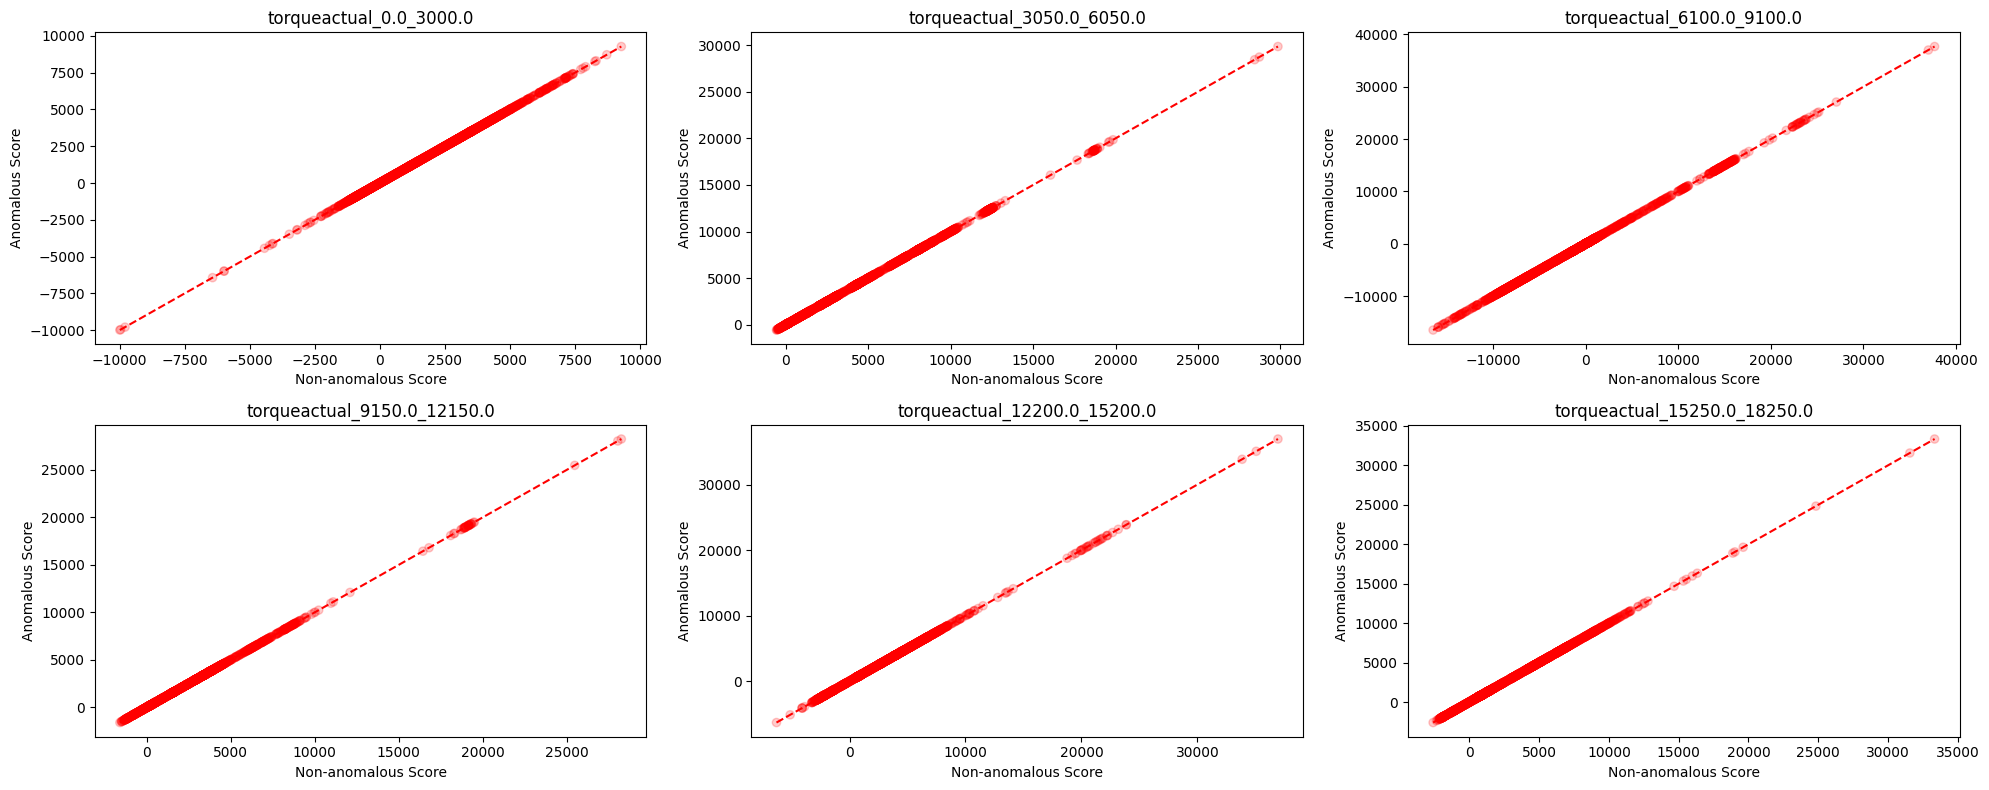

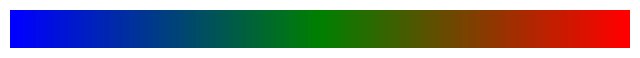

In [28]:
scatter(log_probs, "non-anomalous")

# Anomalies Log-prob Distributions

In [14]:
# Create Posterior Log-probabilities
log_probs = pd.read_csv("models/hmm/results/log_probs.csv")

# Noise Factory
noise = NoiseFactory(tl)

In [16]:
def save_results(results, log_probs):
    results_df = pd.DataFrame(
        results,
        columns=[
            "id",
            "spectrum",
            "anom_params",
            "log_prob",
            "anom_type",
        ],
    )

    log_probs = pd.concat([results_df, log_probs])
    log_probs.to_csv("models/hmm/results/log_probs.csv", index=False)
    return results_df, log_probs


def plot_hist_log_probs(log_probs, anom_type):
    log_probs_anom = log_probs[
        log_probs["anom_type"].isin(["non-anomalous", anom_type])
    ]
    log_probs_norm = log_probs_anom[log_probs_anom["anom_type"] == "non-anomalous"]
    log_probs_anom = log_probs_anom[log_probs_anom["anom_type"] == anom_type]

    spectrums = log_probs["spectrum"].unique()
    fig, ax = plt.subplots(2, int(len(spectrums) / 2), figsize=(20, 8))
    for i, spectrum in enumerate(spectrums):
        norm = log_probs_norm[log_probs_norm["spectrum"] == spectrum]
        anom = log_probs_anom[log_probs_anom["spectrum"] == spectrum]
        ax.flat[i].hist(
            norm["log_prob"], density=True, bins=100, alpha=0.5, label="Non-anomalous"
        )
        ax.flat[i].hist(
            anom["log_prob"], density=True, bins=100, alpha=0.5, label="Anomalous"
        )

        ax.flat[i].set_title(f"{spectrum}")
        ax.flat[i].legend()

    fig.suptitle(f"Anomalies Log-Prob Distribution -- {anom_type.upper()}")
    fig.tight_layout()
    plt.show()


def color_gradient():
    N = 100

    # Define a color gradient: blue to green to red
    colors = ["blue", "green", "red"]
    cmap_name = "custom_gradient"

    # Create a colormap
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=N)

    # Display the colormap
    _, ax = plt.subplots(figsize=(8, 0.5))
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))
    ax.imshow(gradient, aspect='auto', cmap=cm)
    ax.set_axis_off()
    plt.show()


def scatter(log_probs, anom_type):
    log_probs_anom = log_probs[
        log_probs["anom_type"].isin(["non-anomalous", anom_type])
    ]
    log_probs_norm = log_probs_anom[log_probs_anom["anom_type"] == "non-anomalous"]
    log_probs_anom = log_probs_anom[log_probs_anom["anom_type"] == anom_type]

    spectrums = log_probs["spectrum"].unique()
    colors = ["blue", "green", "red"]
    cmap_name = "custom_gradient"
    fig, ax = plt.subplots(2, int(len(spectrums) / 2), figsize=(20, 8))
    for i, spectrum in enumerate(spectrums):
        norm = log_probs_norm[log_probs_norm["spectrum"] == spectrum]
        anom = log_probs_anom[log_probs_anom["spectrum"] == spectrum]

        n = len(anom["anom_params"].unique())
        cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n)
        for j, param in enumerate(anom["anom_params"].unique()):
            anom_param = anom[anom["anom_params"] == param]

            ax.flat[i].scatter(
                norm["log_prob"],
                anom_param[f"log_prob"],
                c=[cm(j/n)] * len(anom_param),
                alpha=0.2,
                label=param
            )
        
        ax.flat[i].set_title(spectrum)
        x_min_max = [
            min(norm["log_prob"].min(), anom["log_prob"].min()),
            max(norm["log_prob"].max(), anom["log_prob"].max()),
        ]
        ax.flat[i].plot(x_min_max, x_min_max, "r--")
        plt.setp(ax.flat[i], xlabel="Non-anomalous Score", ylabel="Anomalous Score")

    fig.tight_layout()
    plt.show()
    
    color_gradient()
    

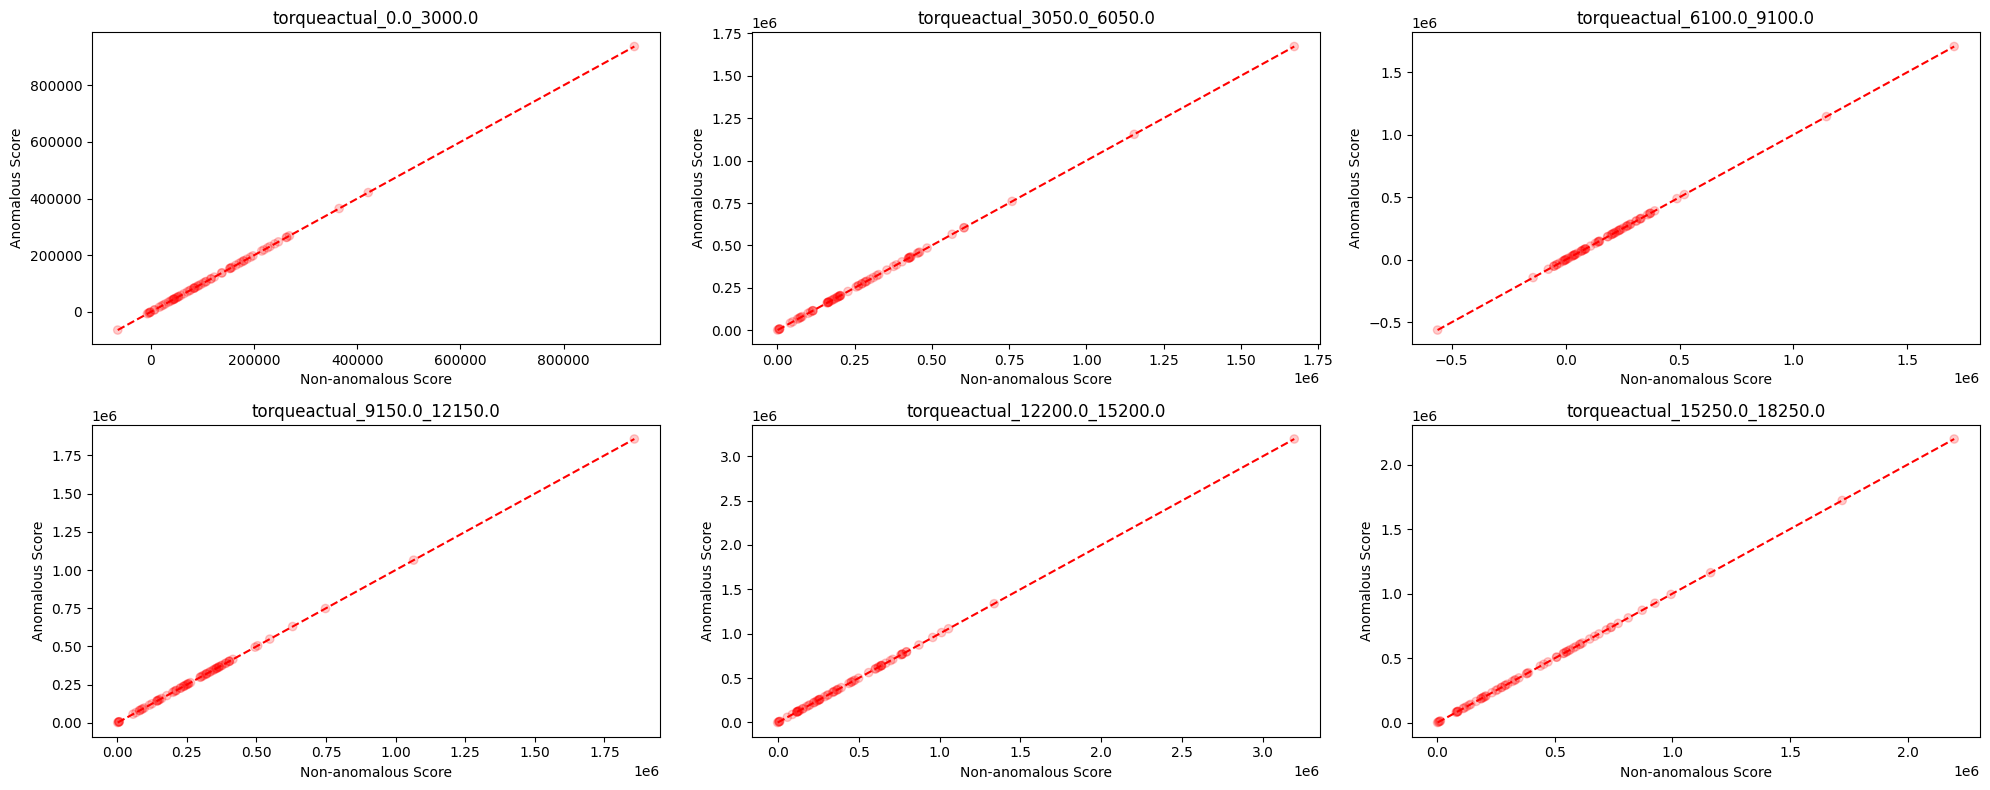

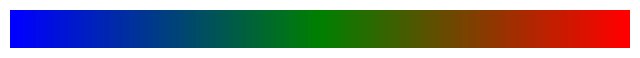

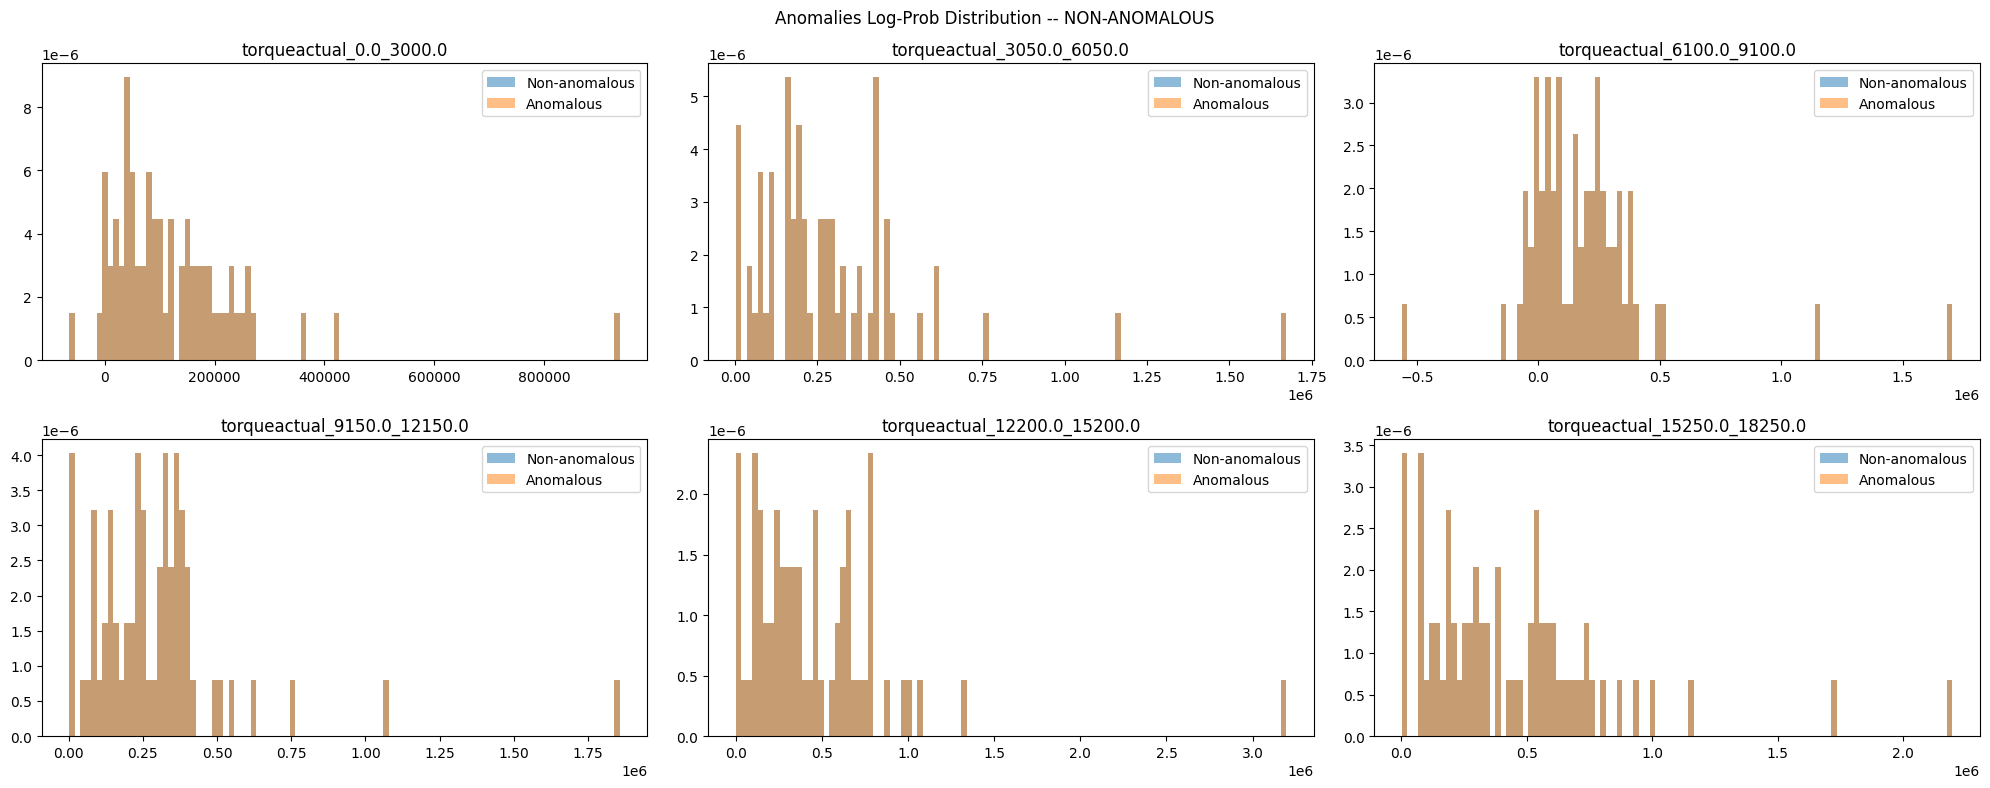

In [20]:
print()
scatter(log_probs, "non-anomalous")
plot_hist_log_probs(log_probs, "non-anomalous")

## Point Anomalies

In [10]:
values = []
for spectrum, model in models.items():
    for _id, sample, std, num in noise.gen_point_anomalies():
        log_prob = model.posterior_prob(sample)
        values.append(
            [
                _id,
                spectrum,
                json.dumps({"std": std, "num": num}),
                log_prob,
                "point_anomaly",
            ]
        )

point_log_prob_df, log_probs = save_results(values, log_probs)
point_log_prob_df.head()

,id,spectrum,anom_params,log_prob,anom_type
0,7600-100440|2022-11-10_09:42:57,torqueactual_0.0_3000.0,"{""std"": 1.0, ""num"": 5}",890.110852,point_anomaly
1,7600-100440|2022-12-08_09:40:32,torqueactual_0.0_3000.0,"{""std"": 1.0, ""num"": 5}",661.620878,point_anomaly
2,7600-100440|2022-02-28_04:51:33,torqueactual_0.0_3000.0,"{""std"": 1.0, ""num"": 5}",340.410176,point_anomaly
3,7600-100440|2022-01-13_04:57:50,torqueactual_0.0_3000.0,"{""std"": 1.0, ""num"": 5}",974.874535,point_anomaly
4,7600-100440|2022-01-26_06:34:30,torqueactual_0.0_3000.0,"{""std"": 1.0, ""num"": 5}",915.394934,point_anomaly


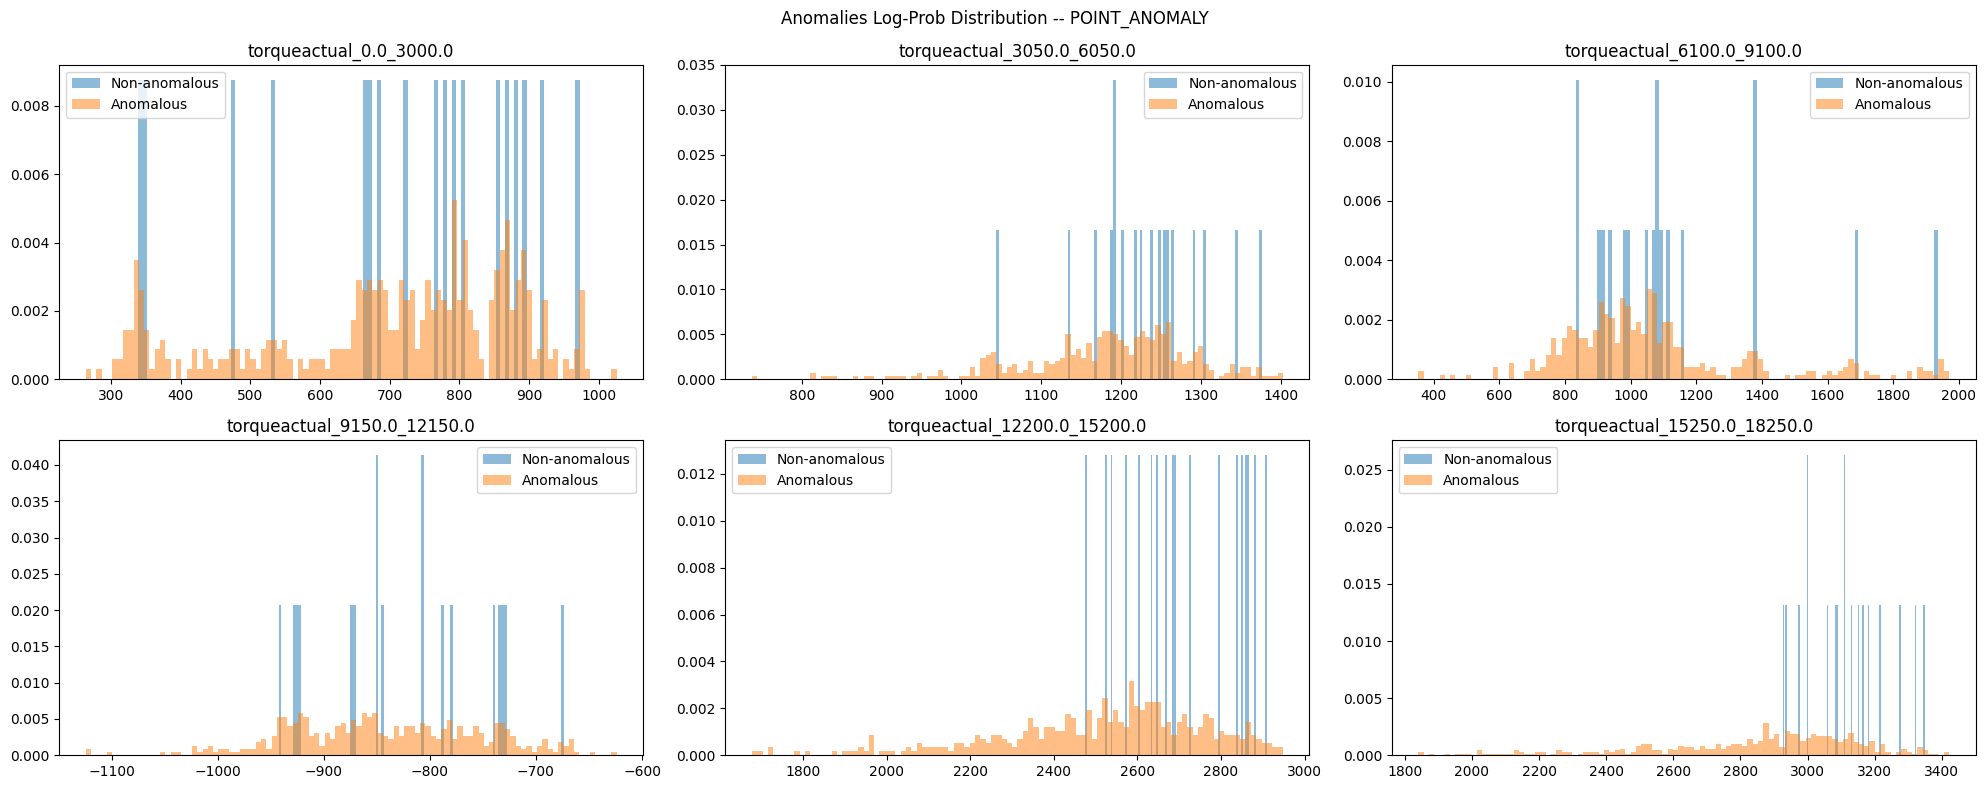

In [11]:
plot_hist_log_probs(log_probs, "point_anomaly")

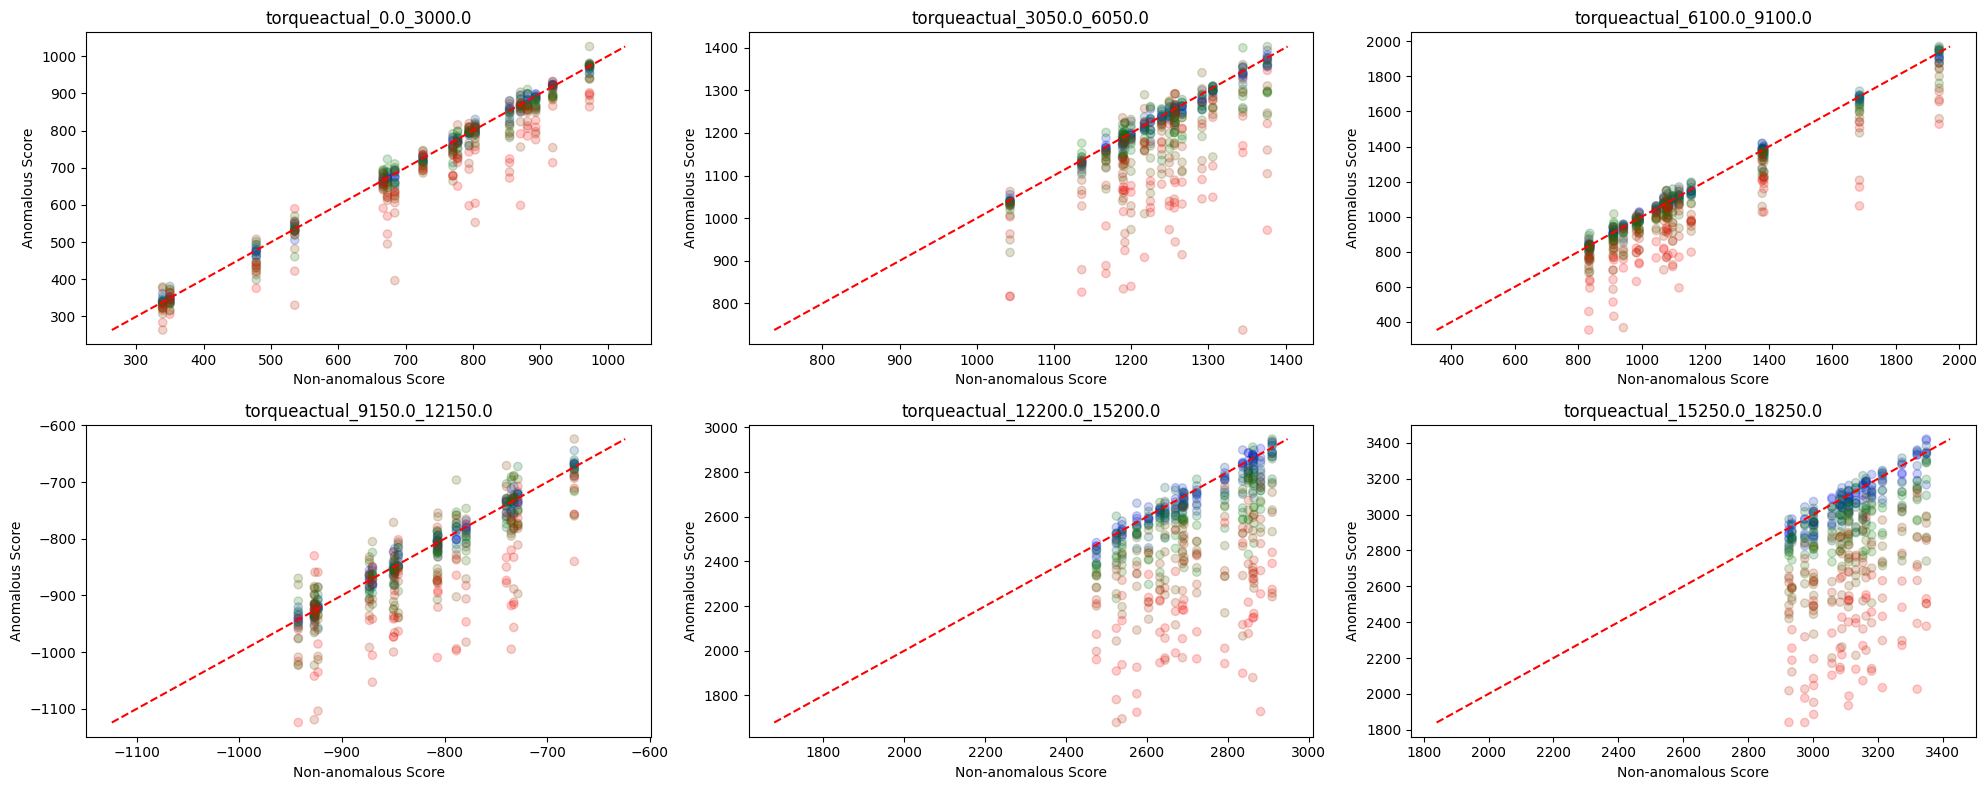

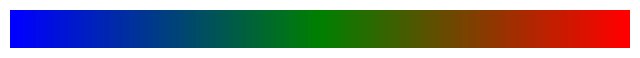

In [12]:
scatter(log_probs, "point_anomaly")

# Gaussian Anomalies

In [13]:
values = []
for spectrum, model in models.items():
    for _id, sample, std in noise.gen_gaussian_anomalies():
        log_prob = model.posterior_prob(sample)
        values.append(
            [
                _id,
                spectrum,
                json.dumps({"std": std}),
                log_prob,
                "gaussian_anomaly",
            ]
        )

gaussian_log_prob_df, log_probs = save_results(values, log_probs)
gaussian_log_prob_df.head()

,id,spectrum,anom_params,log_prob,anom_type
0,7600-100440|2022-11-10_09:42:57,torqueactual_0.0_3000.0,"{""std"": 0.01}",892.872315,gaussian_anomaly
1,7600-100440|2022-12-08_09:40:32,torqueactual_0.0_3000.0,"{""std"": 0.01}",661.139684,gaussian_anomaly
2,7600-100440|2022-02-28_04:51:33,torqueactual_0.0_3000.0,"{""std"": 0.01}",340.699991,gaussian_anomaly
3,7600-100440|2022-01-13_04:57:50,torqueactual_0.0_3000.0,"{""std"": 0.01}",972.776694,gaussian_anomaly
4,7600-100440|2022-01-26_06:34:30,torqueactual_0.0_3000.0,"{""std"": 0.01}",916.445561,gaussian_anomaly


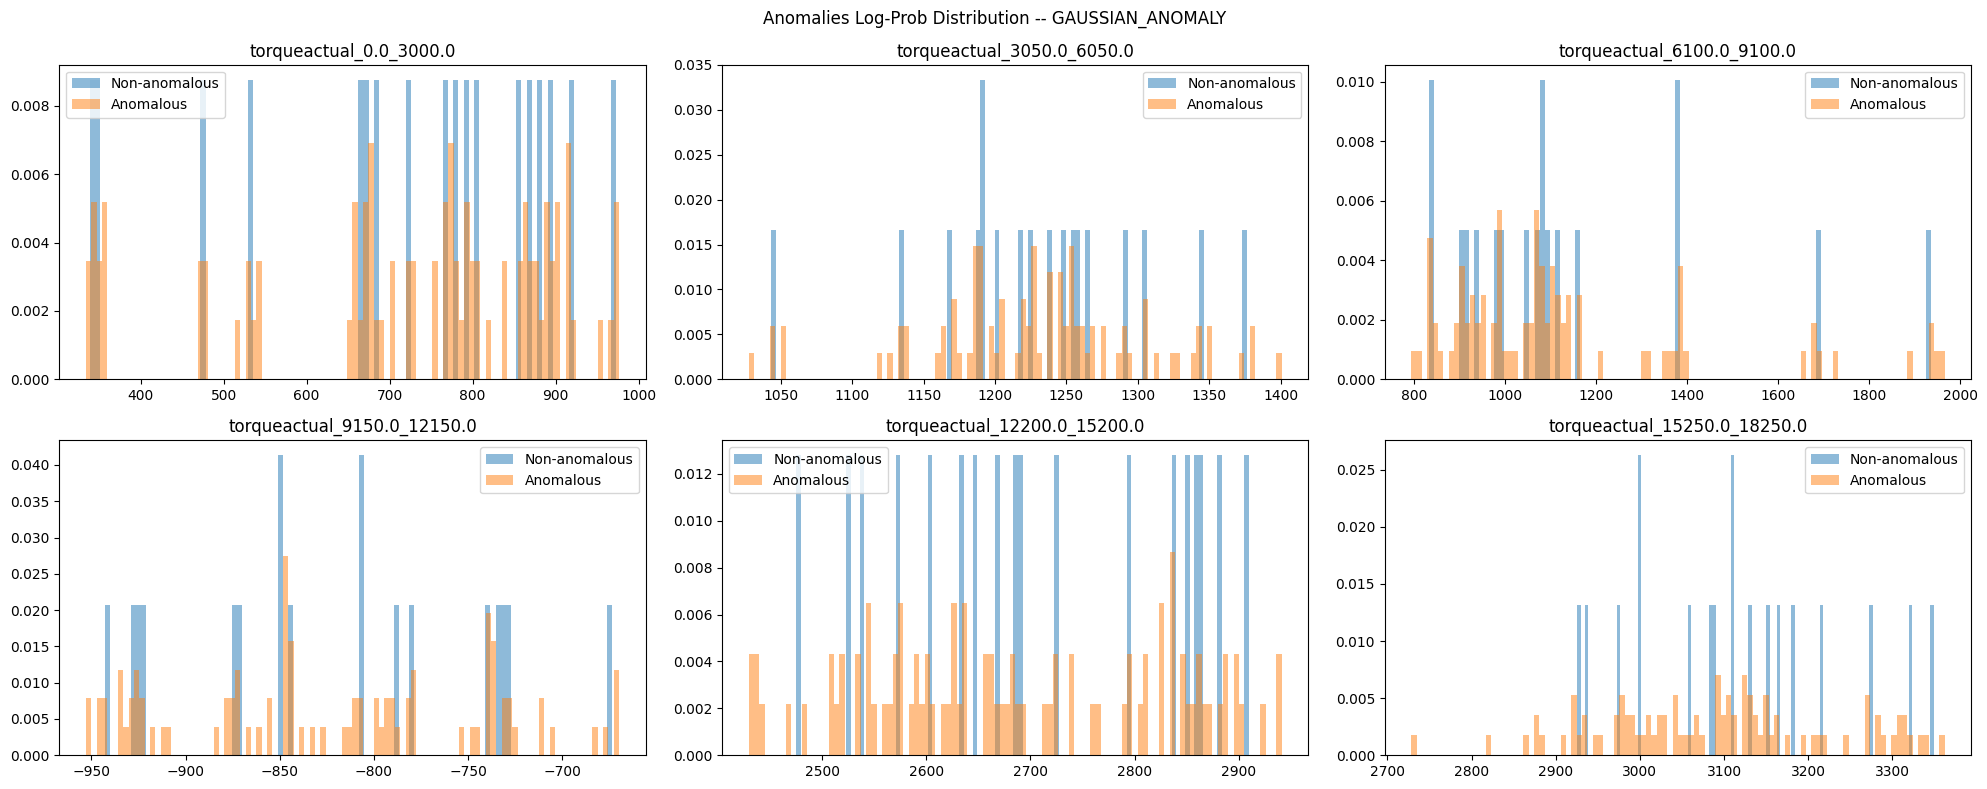

In [14]:
plot_hist_log_probs(log_probs, "gaussian_anomaly")

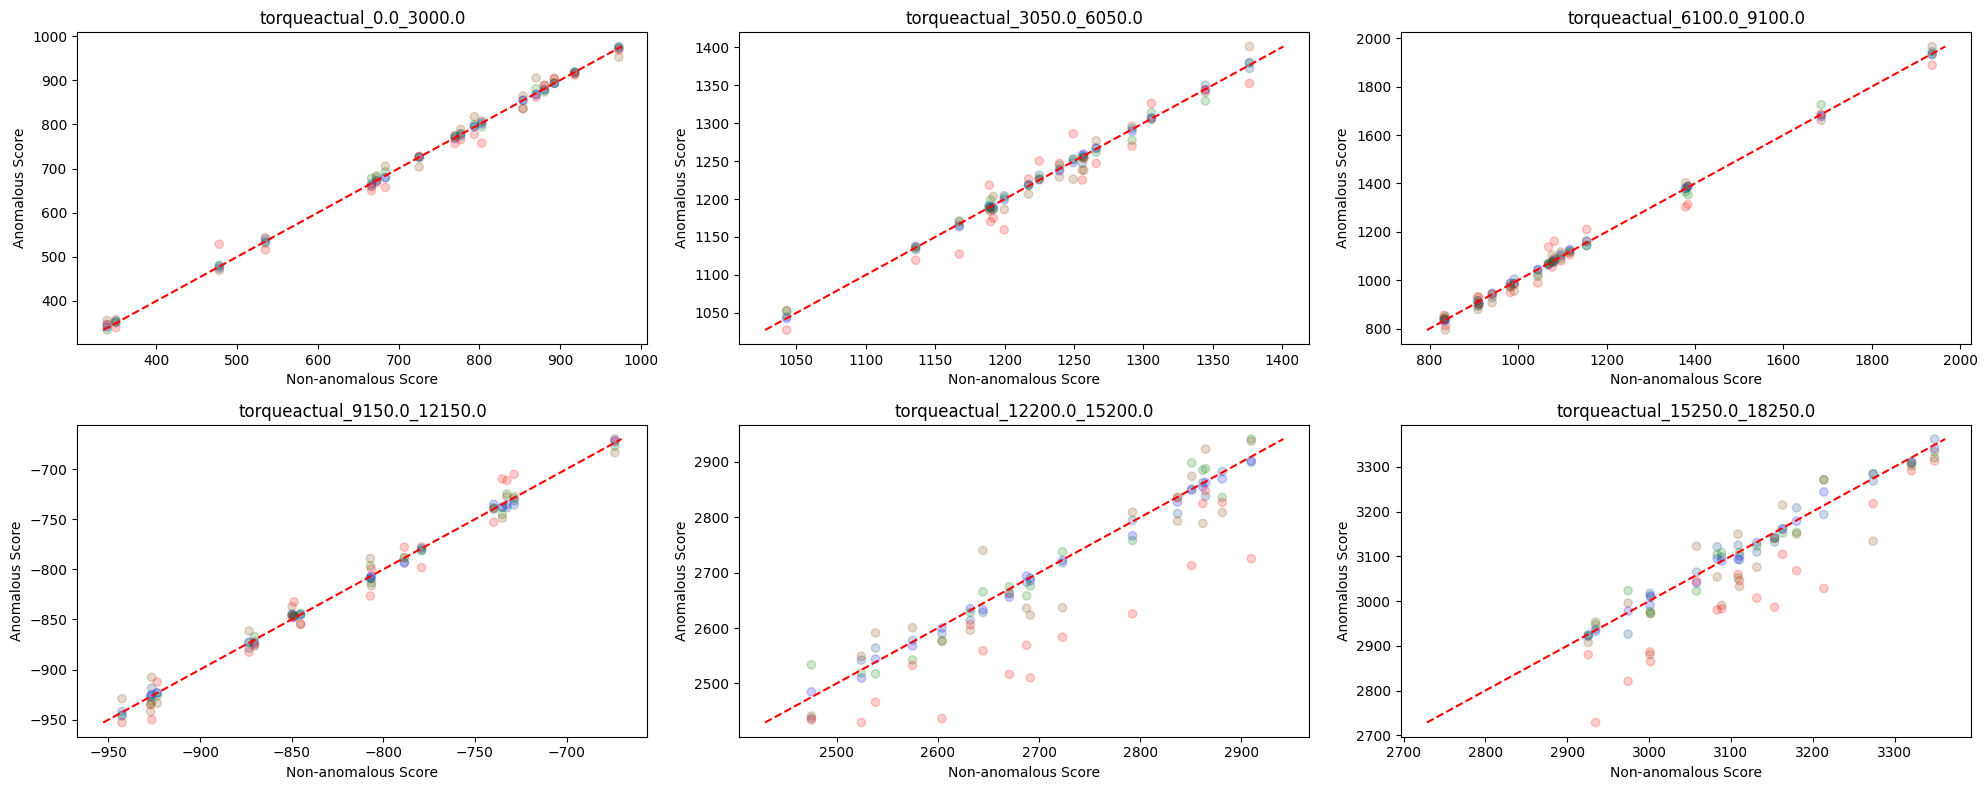

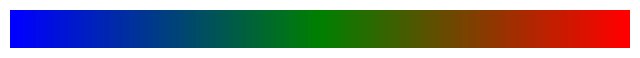

In [15]:
scatter(log_probs, "gaussian_anomaly")

# Shift Anomalies

In [17]:
values = []
for spectrum, model in models.items():
    for _id, sample, start, length, strength in noise.gen_shift_anomaly():
        log_prob = model.posterior_prob(sample)
        values.append(
            [
                _id,
                spectrum,
                json.dumps({"start": start, "length": length, "stregth": strength}),
                log_prob,
                "shift_anomaly",
            ]
        )

gaussian_log_prob_df, _ = save_results(values, log_probs)
gaussian_log_prob_df.head()

ValueError: forward pass failed with underflow; consider using implementation='log' instead

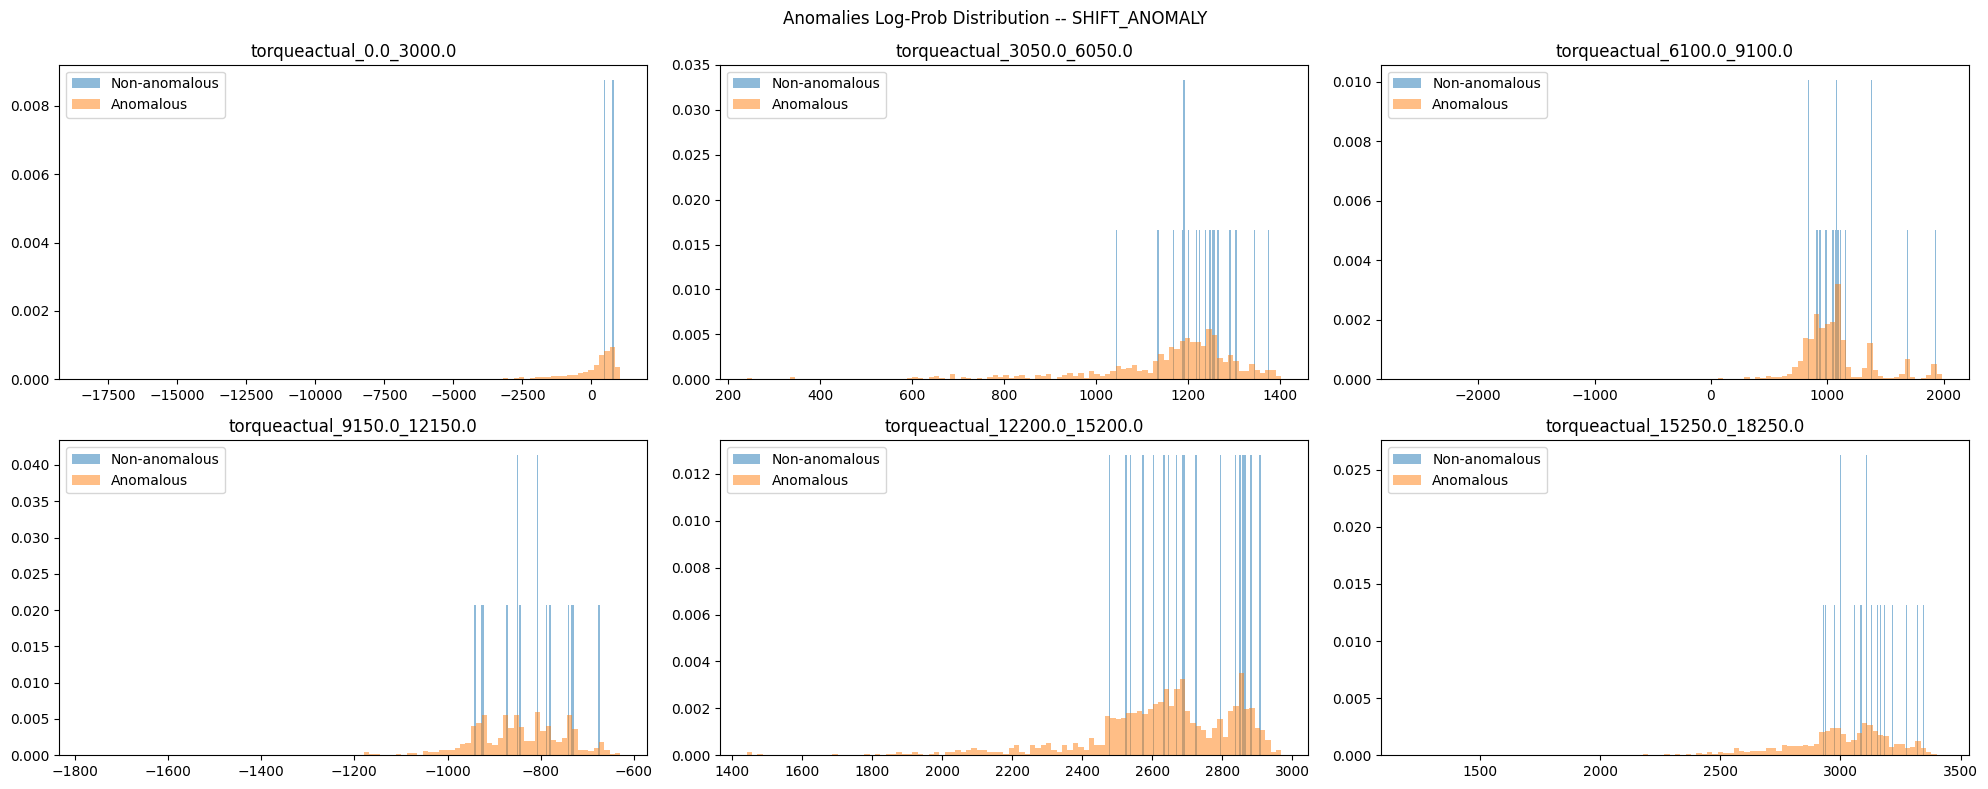

In [56]:
plot_hist_log_probs(log_probs, "shift_anomaly")

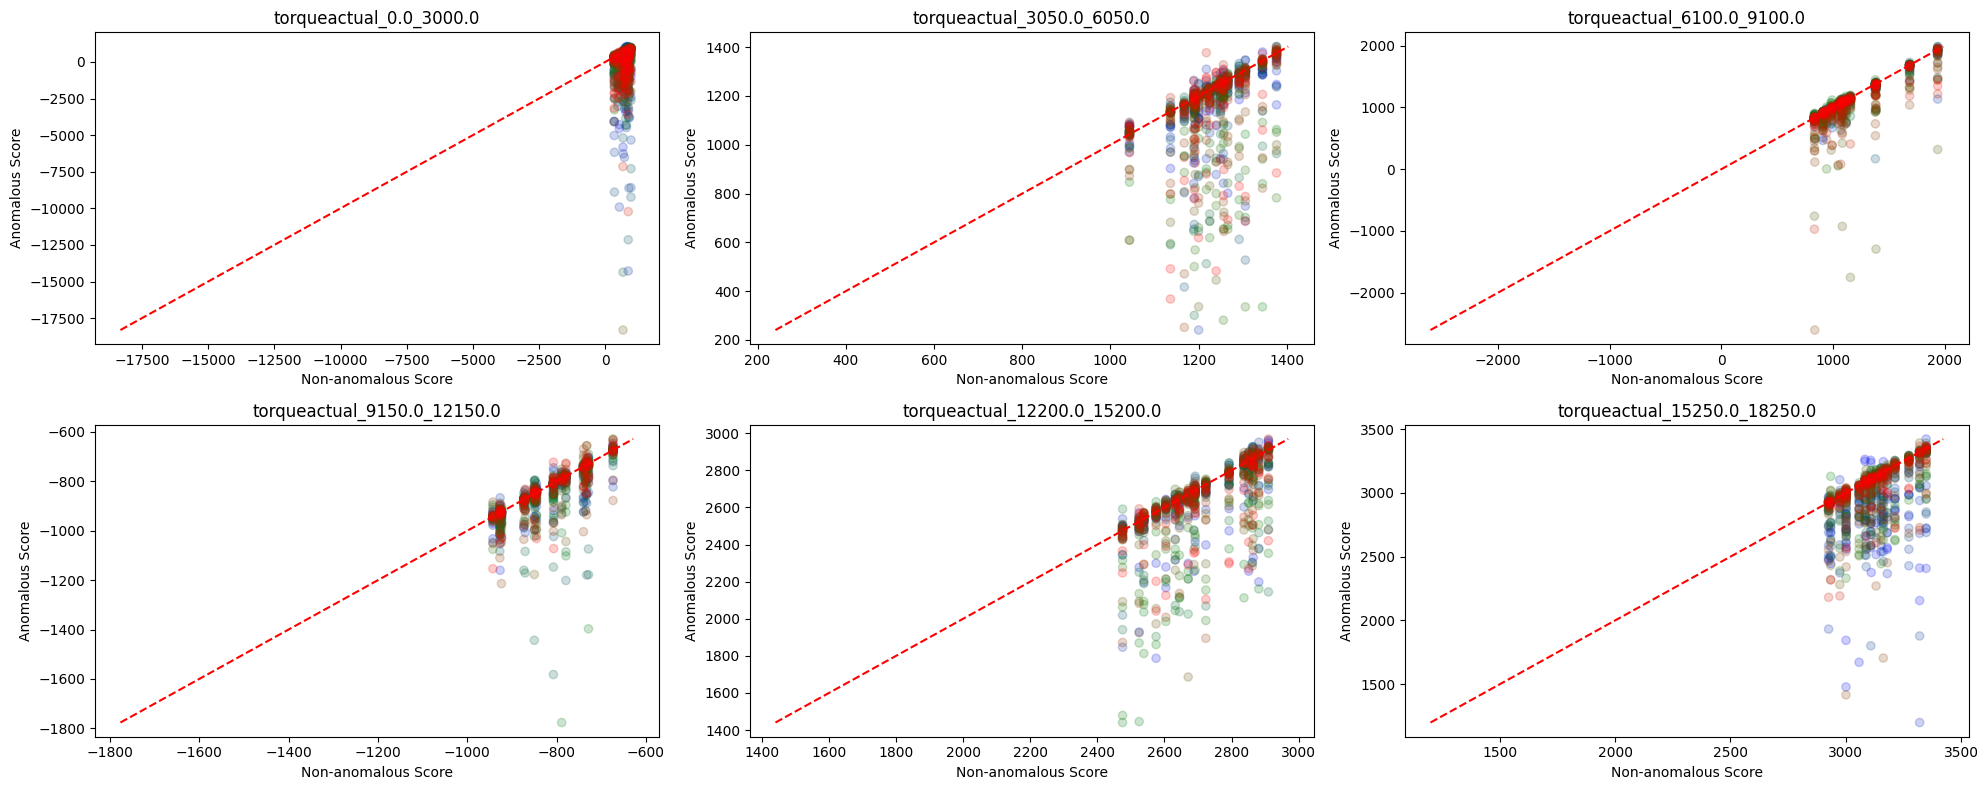

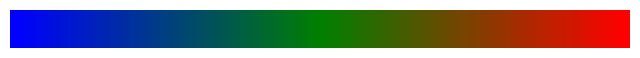

In [57]:
scatter(log_probs, "shift_anomaly")

# Sinusoidal Anomaly

In [18]:
values = []
for spectrum, model in models.items():
    for _id, sample, length, amplitude in noise.gen_sinusoidal_anomaly():
        log_prob = model.posterior_prob(sample)
        values.append(
            [
                _id,
                spectrum,
                json.dumps({"length": length, "amplitude": amplitude}),
                log_prob,
                "sinusoidal_anomaly",
            ]
        )

sinus_log_prob_df, log_probs = save_results(values, log_probs)
sinus_log_prob_df.head()

,id,spectrum,anom_params,log_prob,anom_type
0,7600-100440|2022-11-10_09:42:57,torqueactual_0.0_3000.0,"{""length"": 150, ""amplitude"": 1.0}",886.165684,sinusoidal_anomaly
1,7600-100440|2022-12-08_09:40:32,torqueactual_0.0_3000.0,"{""length"": 150, ""amplitude"": 1.0}",399.584787,sinusoidal_anomaly
2,7600-100440|2022-02-28_04:51:33,torqueactual_0.0_3000.0,"{""length"": 150, ""amplitude"": 1.0}",260.401409,sinusoidal_anomaly
3,7600-100440|2022-01-13_04:57:50,torqueactual_0.0_3000.0,"{""length"": 150, ""amplitude"": 1.0}",859.856575,sinusoidal_anomaly
4,7600-100440|2022-01-26_06:34:30,torqueactual_0.0_3000.0,"{""length"": 150, ""amplitude"": 1.0}",821.742544,sinusoidal_anomaly


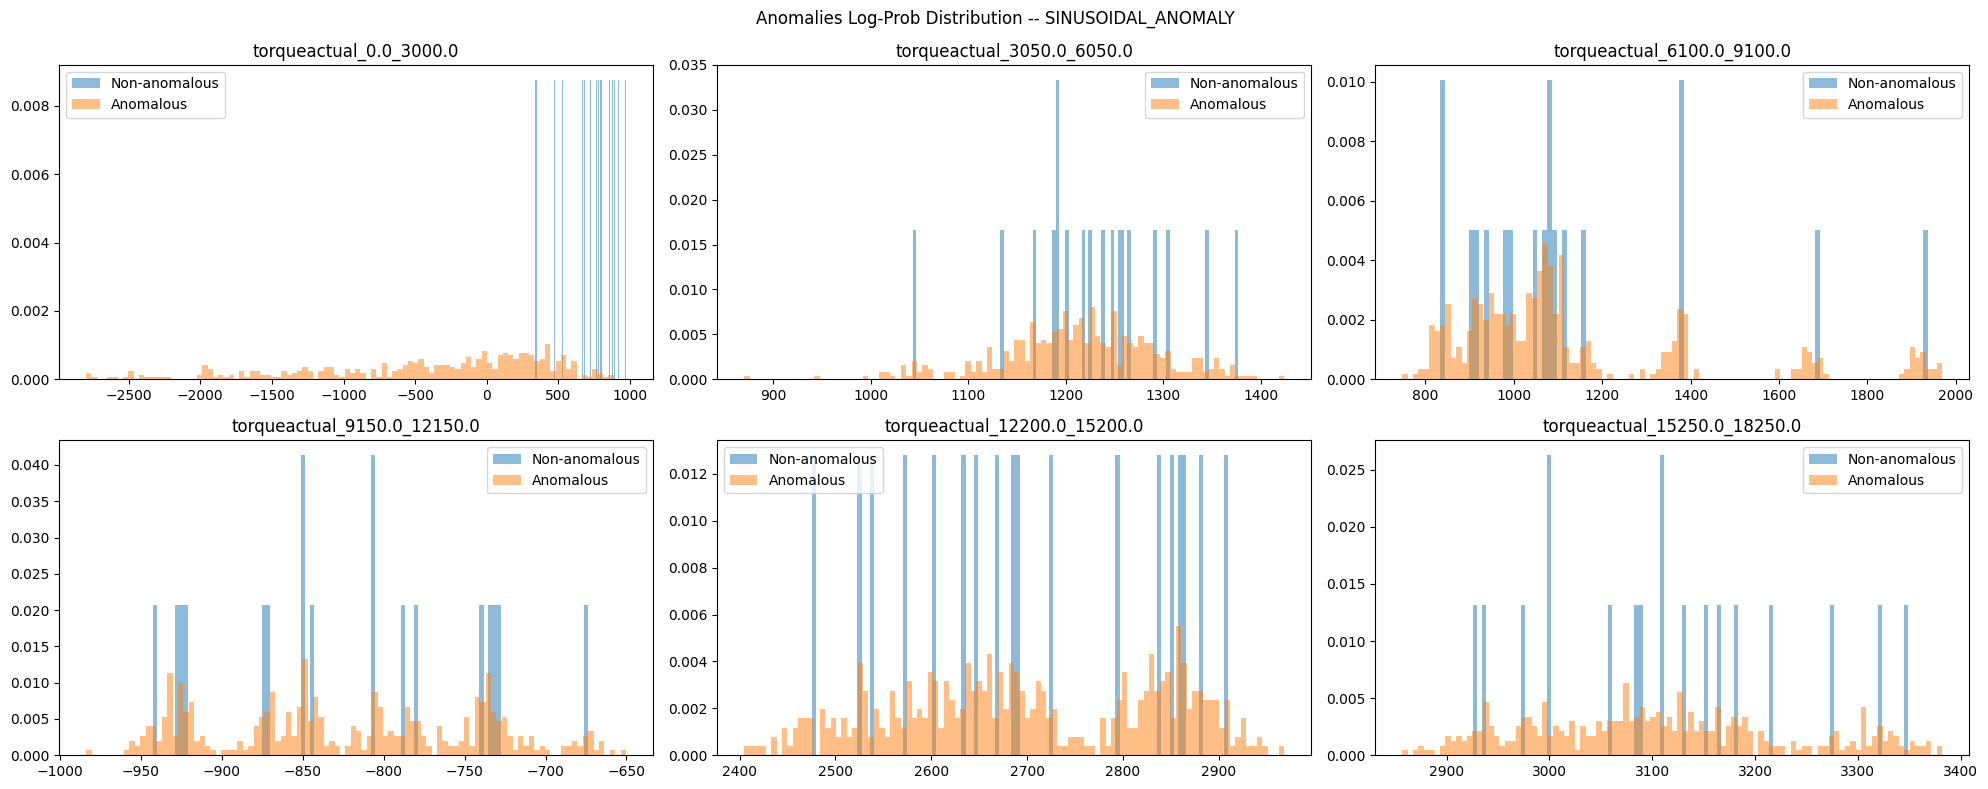

In [19]:
plot_hist_log_probs(log_probs, "sinusoidal_anomaly")

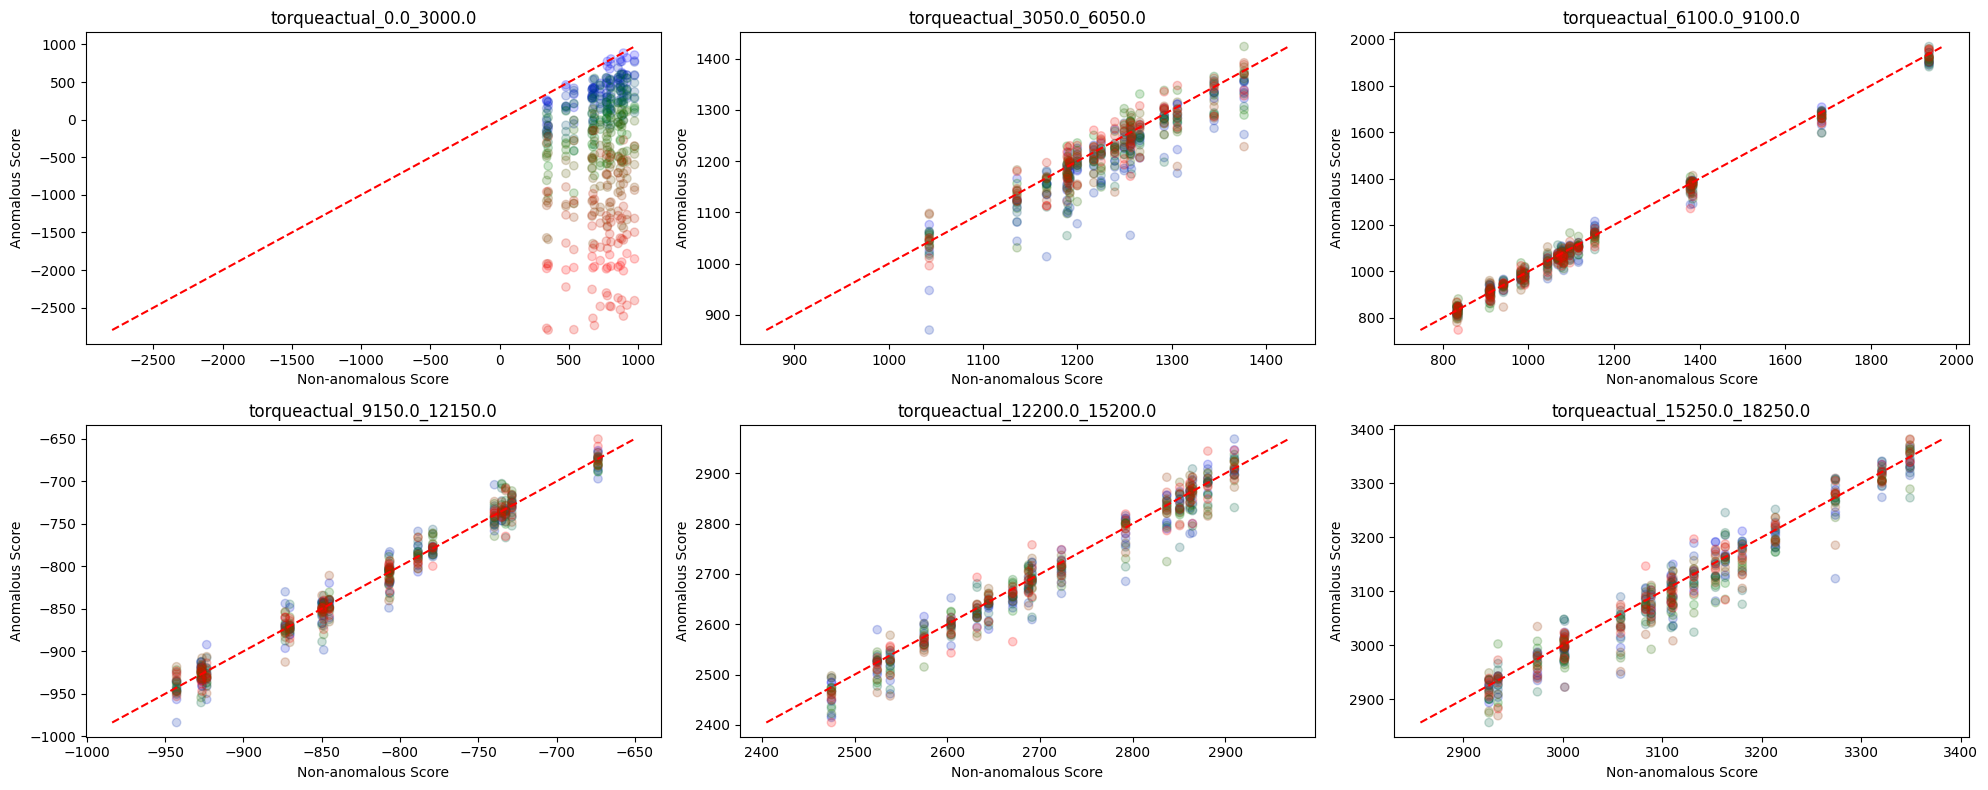

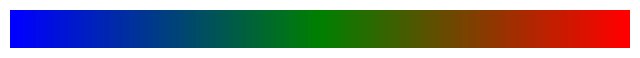

In [20]:
scatter(log_probs, "sinusoidal_anomaly")

---

# SVM

In [21]:
log_probs_nom = log_probs[log_probs["anom_type"] == "non-anomalous"]
log_probs_nom = (
    log_probs_nom[["id", "spectrum", "log_prob"]]
    .sort_values(["id", "spectrum"])
    .groupby(["id"])
    .agg({"log_prob": lambda x: [i for i in x]})
    .reset_index()
)
log_probs_nom["anomaly"] = False
log_probs_nom = log_probs_nom.drop(columns=["id"])

In [22]:
log_probs_anom = log_probs[log_probs["anom_type"] != "non-anomalous"]
log_probs_anom = (
    log_probs_anom[["id", "spectrum", "anom_type", "anom_params", "log_prob"]]
    .sort_values(["id", "anom_params", "spectrum"])
    .groupby(["id", "anom_params"])
    .agg({"log_prob": lambda x: [i for i in x]})
    .reset_index()
    .drop(columns=["id", "anom_params"])
)
log_probs_anom["anomaly"] = True
log_probs_anom_sampled = log_probs_anom.sample(18)

log_probs_svm = pd.concat([log_probs_nom, log_probs_anom_sampled])
log_probs_svm = shuffle(log_probs_svm)

X = np.array(log_probs_svm["log_prob"].values.tolist())
y = log_probs_svm["anomaly"].values

In [23]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 100.0, 'gamma': 1e-08} with a score of 0.82


In [24]:
classifier = SVC(C=0.1, gamma=0.1)
classifier.fit(X, y)

SVC(C=0.1, gamma=0.1)

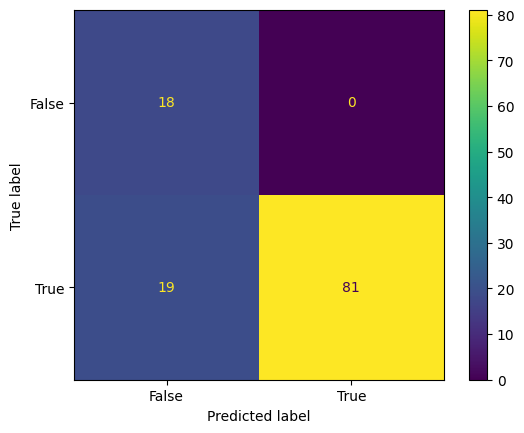

In [25]:
log_probs_anom_sampled = log_probs_anom.sample(100)

log_probs_svm = pd.concat([log_probs_nom, log_probs_anom_sampled])
log_probs_svm = shuffle(log_probs_svm)

X = np.array(log_probs_svm["log_prob"].values.tolist())
y = log_probs_svm["anomaly"].values

y_pred = classifier.predict(X)
cm = confusion_matrix(y, y_pred, labels=classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

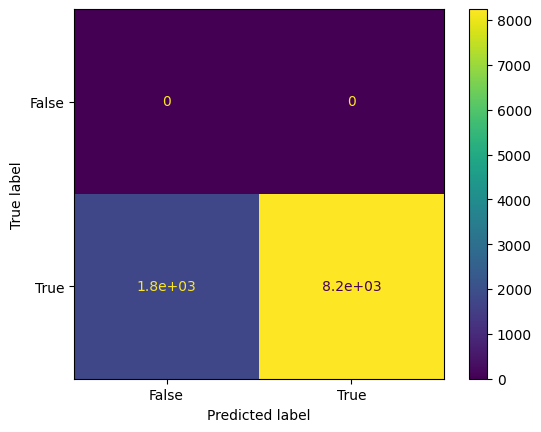

In [26]:
cm = np.zeros((2,2))

for i in range(200):
    log_probs_anom_sampled = log_probs_anom.sample(50)

    log_probs_svm = shuffle(log_probs_anom_sampled)

    X = np.array(log_probs_svm["log_prob"].values.tolist())
    y = log_probs_svm["anomaly"].values

    y_pred = classifier.predict(X)
    cm_ = confusion_matrix(y, y_pred, labels=classifier.classes_)
    cm = cm + cm_


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.show()

In [27]:
fpr = cm[1][0] / (cm[1][0]+cm[1][1])
fpr

0.1757